🔹 STEP 1: Import Libraries & Set Theme

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

🔹 STEP 2: Load Data & Basic Cleaning

In [3]:
df = pd.read_csv("healthcare_readmission_dummy.csv")  # Make sure this file is in your notebook folder

# Drop rows where critical fields are missing
df.dropna(subset=['DischargeType', 'PhysicianNotes'], inplace=True)

# Convert target to binary (Yes = 1, No = 0)
df['Readmitted'] = df['Readmitted'].map({'Yes': 1, 'No': 0})

🔹 STEP 3: Encode Categorical Columns

In [4]:
label_encoders = {}
for col in ['Gender', 'DiagnosisCode', 'DischargeType', 'FollowUpScheduled']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

🔹 STEP 4: Exploratory Visuals

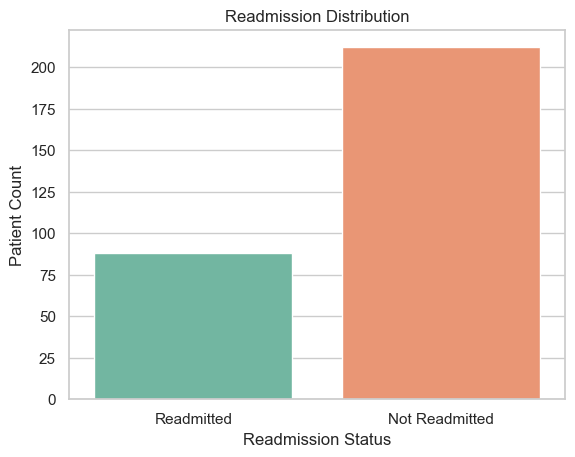

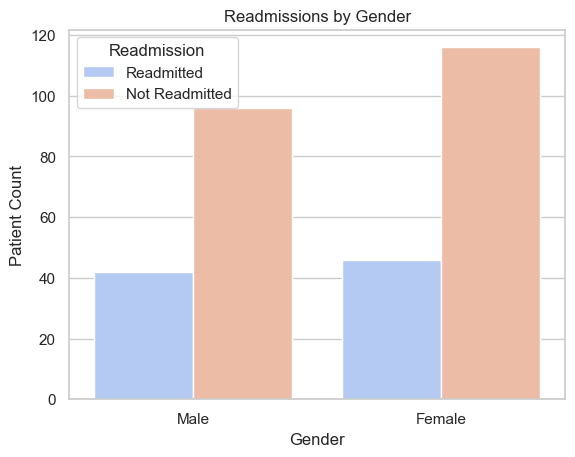

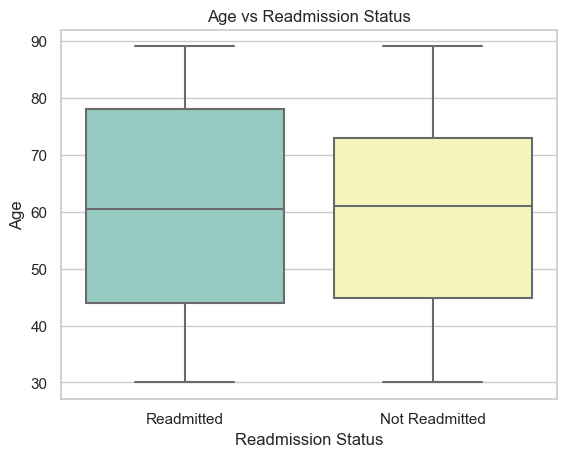

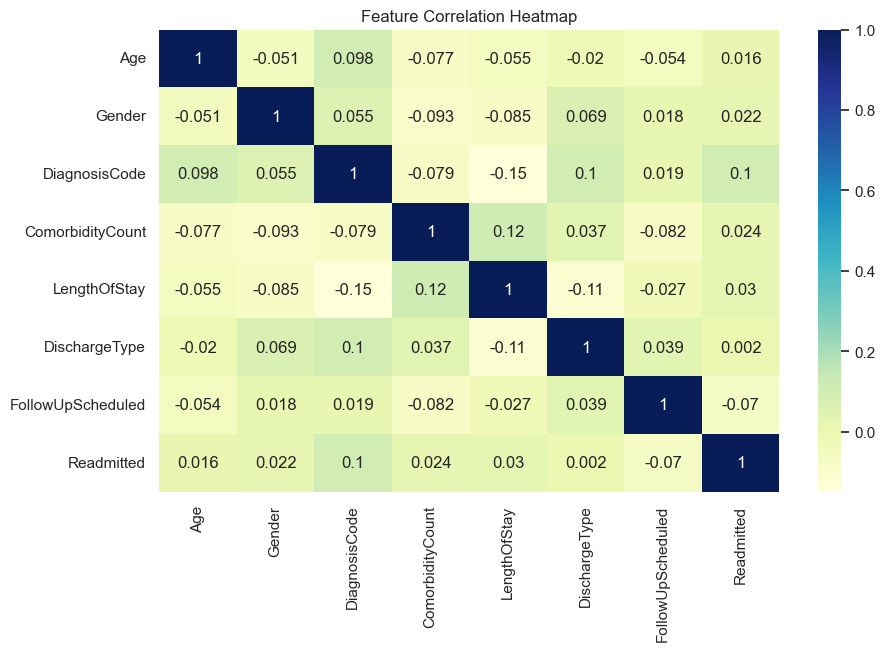

In [7]:
# Create readable labels for visualization only
df['ReadmissionLabel'] = df['Readmitted'].map({0: 'Not Readmitted', 1: 'Readmitted'})
df['GenderLabel'] = df['Gender'].map({label_encoders['Gender'].transform(['Female'])[0]: 'Female',
                                      label_encoders['Gender'].transform(['Male'])[0]: 'Male'})

# 🔹 Distribution of Readmissions
sns.countplot(x='ReadmissionLabel', data=df, palette='Set2')
plt.title("Readmission Distribution")
plt.xlabel("Readmission Status")
plt.ylabel("Patient Count")
plt.show()

# 🔹 Gender-wise Readmission Comparison
sns.countplot(x='GenderLabel', hue='ReadmissionLabel', data=df, palette='coolwarm')
plt.title("Readmissions by Gender")
plt.xlabel("Gender")
plt.ylabel("Patient Count")
plt.legend(title="Readmission")
plt.show()

# 🔹 Age vs Readmission (Boxplot)
sns.boxplot(x='ReadmissionLabel', y='Age', data=df, palette='Set3')
plt.title("Age vs Readmission Status")
plt.xlabel("Readmission Status")
plt.ylabel("Age")
plt.show()

# 🔹 Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['PatientID', 'PhysicianNotes', 'ReadmissionLabel', 'GenderLabel'], axis=1).corr(), annot=True, cmap="YlGnBu")
plt.title("Feature Correlation Heatmap")
plt.show()

📌 Inference: Patients with more comorbidities and longer stays may be more prone to readmissions.

🔹 STEP 5: TF-IDF Vectorization (Physician Notes)

In [14]:
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['PhysicianNotes'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
#tfidf_df.head(0)
##Inference: These 50 key terms capture critical patterns in physician notes such as symptoms or treatments.

🔹 STEP 6: Combine Final Feature Set

In [15]:
X = pd.concat([
    df[['Age', 'Gender', 'DiagnosisCode', 'ComorbidityCount', 'LengthOfStay', 'DischargeType', 'FollowUpScheduled']],
    tfidf_df
], axis=1)
y = df['Readmitted']

🔹 STEP 7: Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🔹 STEP 8: Train Models

In [17]:
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

🔹 STEP 9: Model Evaluation

In [18]:
# Logistic Regression
lr_preds = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))

# Random Forest
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, rf_preds))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        43
           1       0.00      0.00      0.00        17

    accuracy                           0.70        60
   macro avg       0.36      0.49      0.41        60
weighted avg       0.51      0.70      0.59        60

Random Forest Report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        43
           1       0.00      0.00      0.00        17

    accuracy                           0.67        60
   macro avg       0.35      0.47      0.40        60
weighted avg       0.50      0.67      0.57        60



📌 Inference: Compare precision/recall for detecting high-risk patients. Choose best model based on AUC and interpretability.


🔹 STEP 10: ROC Curve

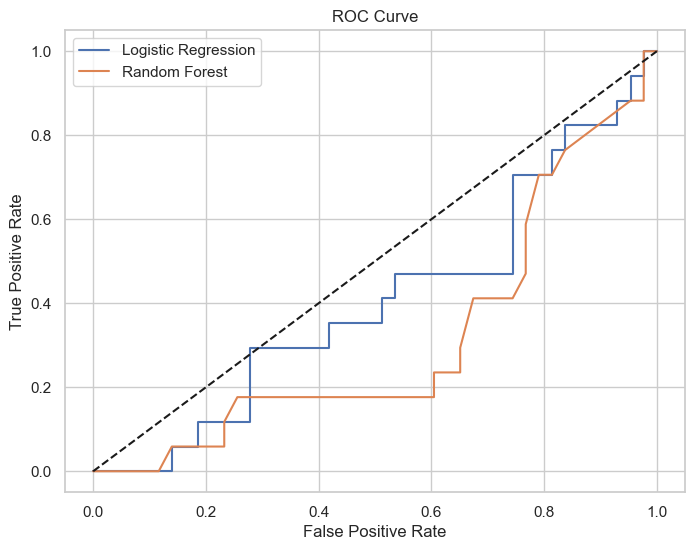

In [19]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

📌 Inference: Area under the curve > 0.80 is ideal. Helps select final model.


🔹 STEP 11: Feature Importance (Random Forest)

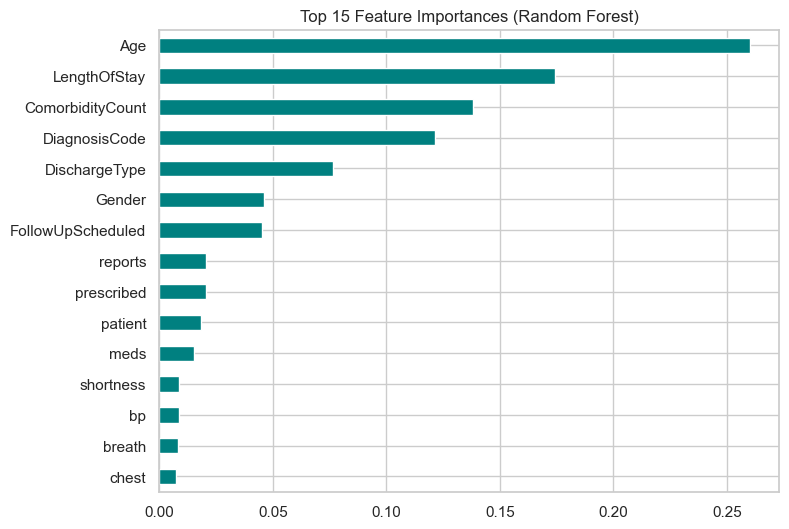

In [20]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]

plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh', color='teal')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

📌 Inference: Use this for clinical explanation of what drives readmission — e.g., comorbidity, follow-up, key symptoms.


🔹 STEP 12: Export Power BI / Dashboard CSV

In [21]:
X_test_export = X_test.copy()
X_test_export['PatientID'] = df.iloc[X_test.index]['PatientID'].values
X_test_export['PredictedReadmission'] = rf_preds
X_test_export['RiskScore'] = rf_probs.round(3)

X_test_export[['PatientID', 'Age', 'RiskScore', 'PredictedReadmission']].to_csv("readmission_model_output.csv", index=False)

print("✅ Power BI-ready summary exported to 'readmission_model_output.csv'")

✅ Power BI-ready summary exported to 'readmission_model_output.csv'


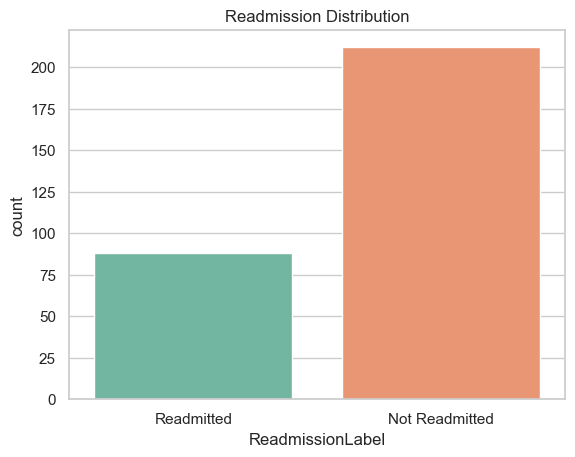

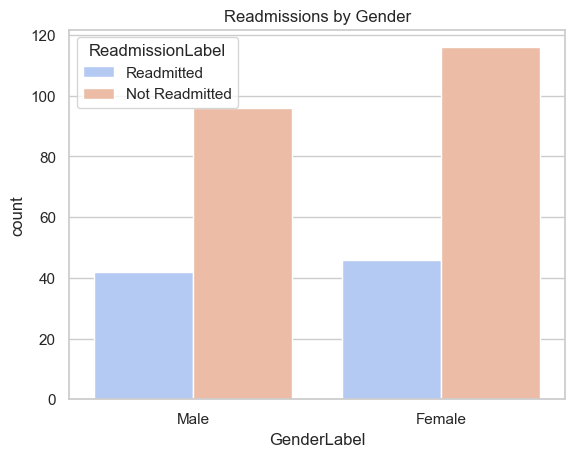

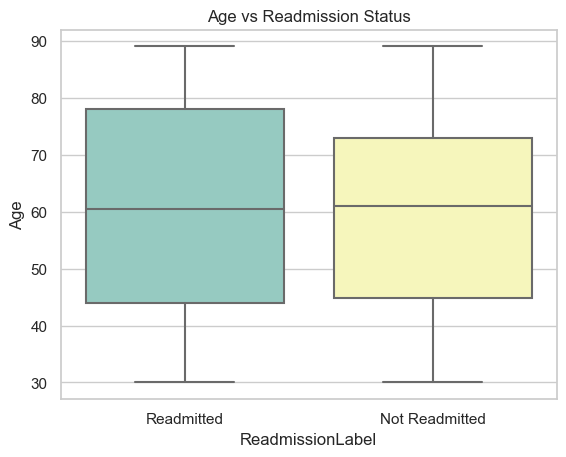

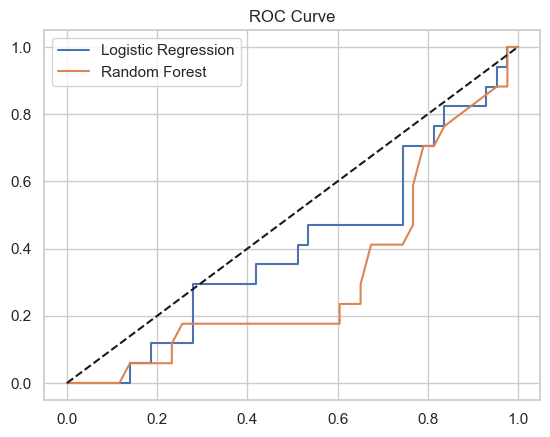

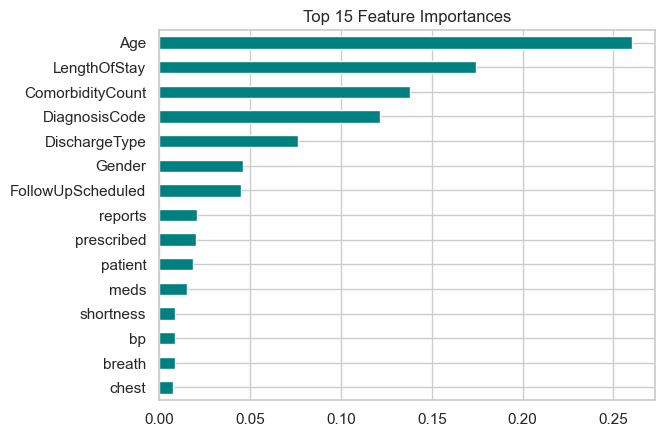

In [23]:
import os
os.makedirs("visuals", exist_ok=True)

# 1. Readmission distribution
plt.figure()
sns.countplot(x='ReadmissionLabel', data=df, palette='Set2')
plt.title("Readmission Distribution")
plt.savefig("visuals/readmission_distribution.png")
plt.show()

# 2. Gender vs Readmission
plt.figure()
sns.countplot(x='GenderLabel', hue='ReadmissionLabel', data=df, palette='coolwarm')
plt.title("Readmissions by Gender")
plt.savefig("visuals/gender_vs_readmission.png")
plt.show()

# 3. Age vs Readmission
plt.figure()
sns.boxplot(x='ReadmissionLabel', y='Age', data=df, palette='Set3')
plt.title("Age vs Readmission Status")
plt.savefig("visuals/age_vs_readmission.png")
plt.show()

# 4. ROC Curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.legend()
plt.savefig("visuals/roc_curve.png")
plt.show()

# 5. Feature Importance
plt.figure()
feat_imp.plot(kind='barh', color='teal')
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.savefig("visuals/feature_importance.png")
plt.show()